## Salient Object Detection Models
Segmentation models produced segmentation masks that did not fit tightly on the main object in input images, at times conflating clear backgrounds as multiple classes.

This notebook tests Salient Object Detection models (SOD), which identify the main object(s) in an image, and produces a binary mask.

We begin by running each model on an example image, before comparing them against each other.

In [ ]:
!pip install onnxruntime --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.4 MB/s eta 0:00:00


In [ ]:
!pip install -q rembg[cli] transparent-background transformers timm accelerate pillow numpy opencv-python pandas matplotlib

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 70.6 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import seaborn as sns

# Models
from rembg import remove as rembg_remove
from transparent_background import Remover
from transformers import AutoModelForImageSegmentation
from torchvision import transforms

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")


/usr/local/lib/python3.12/dist-packages/transparent_background/gui.py:24: UserWarning: Failed to import flet. Ignore this message when you do not need GUI mode.
  warnings.warn('Failed to import flet. Ignore this message when you do not need GUI mode.')


Device: cuda


In [ ]:

def visualise(original, mask, title="Result"):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='inferno')
    plt.title(f"Model {title} Mask")
    plt.axis("off")
    plt.show()

In [ ]:
# The following match the structure of the example available in the shapenet_more_variation dataset, as detailed in the report.
EASY_DIR = "/content/easy"
HARD_DIR = "/content/hard"


#### rembg
https://github.com/danielgatis/rembg

Removes backgrounds in an image.

In [ ]:
INDIV_IMG_PATH = "/content/frame000003.jpg"

In the following, once the binary mask is produced, we use an OpenCV morphological operation (Closing), which helps get rid of small holes inside the foreground object mask.

See here:
https://docs.opencv.org/4.x/d9/d61/tutorial_py_morphological_ops.html

100%|████████████████████████████████████████| 176M/176M [00:00<00:00, 114GB/s]


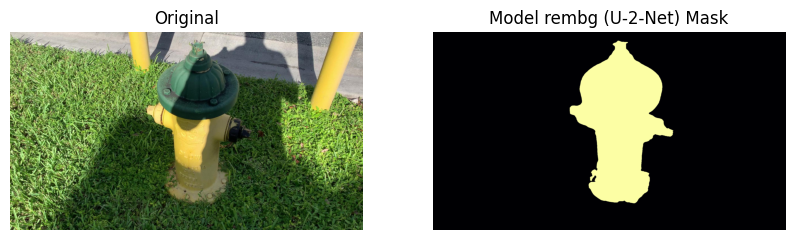

In [ ]:
input_img = cv2.imread(INDIV_IMG_PATH)
input_rgb = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)

output = rembg_remove(input_img)

 # Alpha channel in output represents opacity
  # We threshold the channel to produce a binary mask
alpha = output[..., 3]
binary_mask = (alpha > 127).astype(np.uint8)

kernel = np.ones((3,3), np.uint8)
binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel, iterations=1)

visualise(input_rgb, binary_mask, title="rembg (U-2-Net)")

## InSPyReNet
https://github.com/plemeri/InSPyReNet

/usr/local/lib/python3.12/dist-packages/torch/functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4317.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Settings -> Mode=base, Device=cuda, Torchscript=disabled


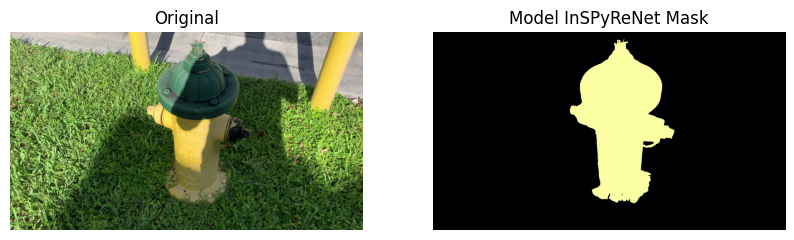

In [ ]:
inspyre = Remover(mode='base', device=device)
pil_img = Image.open(INDIV_IMG_PATH).convert("RGB")

inspyre_output = inspyre.process(pil_img)

# Returns an RGBA image; extract alpha channel
inspyre_mask = np.array(inspyre_output)[:, :, 3]
inspyre_mask = (inspyre_mask > 127).astype(np.uint8)

visualise(pil_img, inspyre_mask, title="InSPyReNet")

## BiRefNet
https://github.com/ZhengPeng7/BiRefNet

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/405 [00:00<?, ?B/s]

BiRefNet_config.py:   0%|          | 0.00/298 [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ZhengPeng7/BiRefNet:
- BiRefNet_config.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


birefnet.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ZhengPeng7/BiRefNet:
- birefnet.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.12/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


model.safetensors:   0%|          | 0.00/444M [00:00<?, ?B/s]

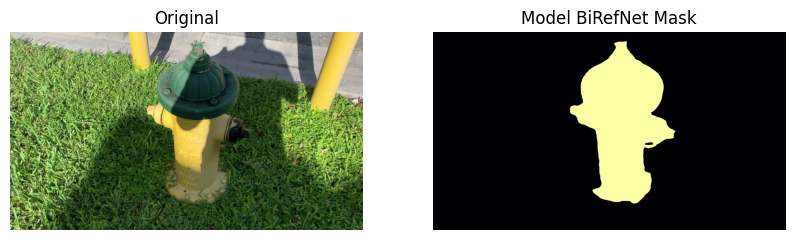

In [ ]:

birefnet = AutoModelForImageSegmentation.from_pretrained('ZhengPeng7/BiRefNet', trust_remote_code=True)
birefnet.to(device).eval()

INFERENCE_SIZE = (384, 384)

biref_transform = transforms.Compose([
    transforms.Resize(INFERENCE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Standard, see inference tutorial.
])

def pred_biref(image):
    input_tensor = biref_transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        preds = birefnet(input_tensor)[-1].sigmoid().cpu()

    # Resize back to original size.
    pred = preds[0].squeeze()
    pil_pred_transformed = transforms.ToPILImage()(pred)
    pil_pred_transformed = pil_pred_transformed.resize(image.size)
    return np.array(pil_pred_transformed)

raw_mask = pred_biref(pil_img)
birefnet_mask = (raw_mask > 127).astype(np.uint8)

visualise(pil_img, birefnet_mask, title="BiRefNet")

## Model Comparison

In [ ]:
def calculate_metrics(pred_map, gt_mask):
    # Normalisation
    if np.max(pred_map) > 1.0:
      pred_map = pred_map / 255.0
    pred_binary = (pred_map > 0.5).astype(float)

    intersection = np.sum(pred_binary * gt_mask)

    # MAE
    mae = np.mean(np.abs(pred_map - gt_mask))

    # IoU
    union = np.sum(pred_binary) + np.sum(gt_mask) - intersection
    iou = intersection / (union + 1e-6)

    # Precision & Recall
    tp = intersection
    fp = np.sum(pred_binary) - tp
    fn = np.sum(gt_mask) - tp

    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)

    # F-Beta (0.3)
    beta2 = 0.3
    f_beta = ((1 + beta2) * precision * recall) / (beta2 * precision + recall + 1e-6)

    return mae, iou, f_beta, precision, recall

In [ ]:
def evaluate(folder_path, diff_label):
    images = sorted([f for f in os.listdir(folder_path) if f.lower().endswith((".png",".jpg",".jpeg"))])
    results = []

    for img_name in images:
        path = os.path.join(folder_path, img_name)
        pil_img = Image.open(path).convert("RGBA")
        cv_img = cv2.imread(path)

        gt_alpha = np.array(pil_img)[:, :, 3]
        gt_mask = (gt_alpha > 0).astype(np.float32)

        # Run Models
        rembg_output = rembg_remove(cv_img)
        rembg_mask = rembg_output[..., 3].astype(np.float32) / 255.0

        inspyre_output = inspyre.process(pil_img.convert("RGB"))
        inspyre_map = np.array(inspyre_output)[..., 3].astype(np.float32) / 255.0

        raw_biref = pred_biref(pil_img.convert("RGB"))
        biref_map = raw_biref.astype(np.float32) / 255.0

        models_maps = {
            "rembg": rembg_mask, "InSPyReNet": inspyre_map, "BiRefNet": biref_map
        }

        for model, pred_map in models_maps.items():
            mae, iou, f_beta, prec, rec = calculate_metrics(pred_map, gt_mask)
            results.append({"Difficulty": diff_label, "Image": img_name, "Model": model, "MAE": mae, "IoU": iou, "F_beta": f_beta, "Precision": prec, "Recall": rec})

    return pd.DataFrame(results)


df_easy = evaluate(EASY_DIR, "Easy")
df_hard = evaluate(HARD_DIR, "Hard")

df = pd.concat([df_easy, df_hard], ignore_index=True)



In [ ]:
df

,Difficulty,Image,Model,MAE,IoU,F_beta,Precision,Recall
0,Easy,00.png,rembg,0.003947,0.989017,0.995668,0.996692,0.992274
1,Easy,00.png,InSPyReNet,0.006284,0.974034,0.993885,1.000000,0.974034
2,Easy,00.png,BiRefNet,0.006738,0.968097,0.979613,0.976063,0.991640
3,Easy,01.png,rembg,0.002772,0.987919,0.994034,0.994131,0.993715
4,Easy,01.png,InSPyReNet,0.003917,0.974649,0.994033,1.000000,0.974649
...,...,...,...,...,...,...,...,...
211,Hard,34.png,InSPyReNet,0.003070,0.985954,0.996503,0.999589,0.986353
212,Hard,34.png,BiRefNet,0.008343,0.953437,0.967207,0.959661,0.993244
213,Hard,35.png,rembg,0.002218,0.984443,0.995777,0.998899,0.985512
214,Hard,35.png,InSPyReNet,0.001897,0.976820,0.994553,1.000000,0.976820


IoU              F_beta                 MAE  \
                           mean       std      mean       std      mean   
Difficulty Model                                                          
Easy       BiRefNet    0.965824  0.006713  0.979474  0.004694  0.005557   
           InSPyReNet  0.983455  0.007649  0.995931  0.001759  0.004124   
           rembg       0.985768  0.006844  0.991189  0.005625  0.003783   
Hard       BiRefNet    0.952101  0.021921  0.972630  0.008550  0.007103   
           InSPyReNet  0.965967  0.032869  0.990910  0.008621  0.006074   
           rembg       0.980257  0.013069  0.988388  0.007028  0.004628   

                                 
                            std  
Difficulty Model                 
Easy       BiRefNet    0.001299  
           InSPyReNet  0.001578  
           rembg       0.000840  
Hard       BiRefNet    0.002784  
           InSPyReNet  0.004497  
           rembg       0.002182

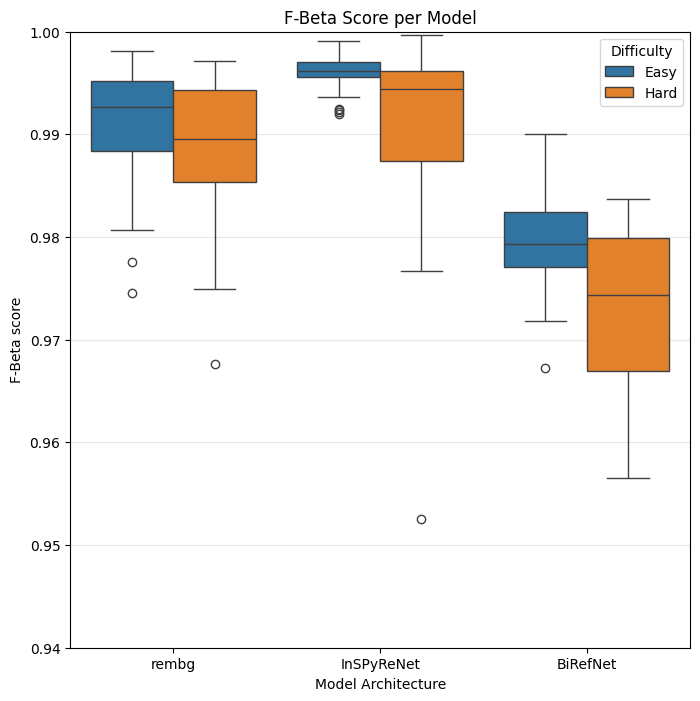

In [ ]:
summary = df.groupby(["Difficulty", "Model"])[["IoU", "F_beta", "MAE"]].agg(['mean', 'std'])
display(summary)

plt.figure(figsize=(8, 8))
sns.boxplot(data=df, x="Model", y="F_beta", hue="Difficulty") # 1.5 IQR as standard, dots are outliers
plt.title("F-Beta Score per Model")
plt.ylabel("F-Beta score")
plt.xlabel("Model Architecture")
plt.ylim(0.94, 1.0)
plt.grid(axis='y', alpha=0.3)
plt.show()

/tmp/ipython-input-1159104860.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=win_counts, x="Model", y="Wins", palette="viridis")


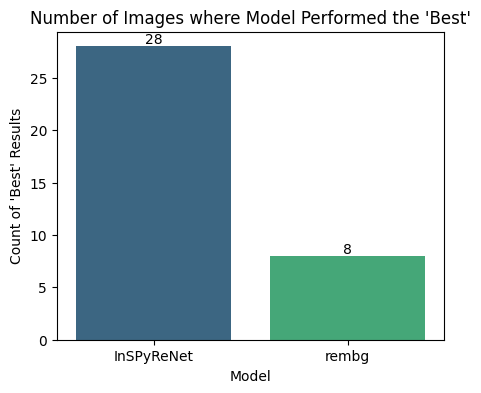

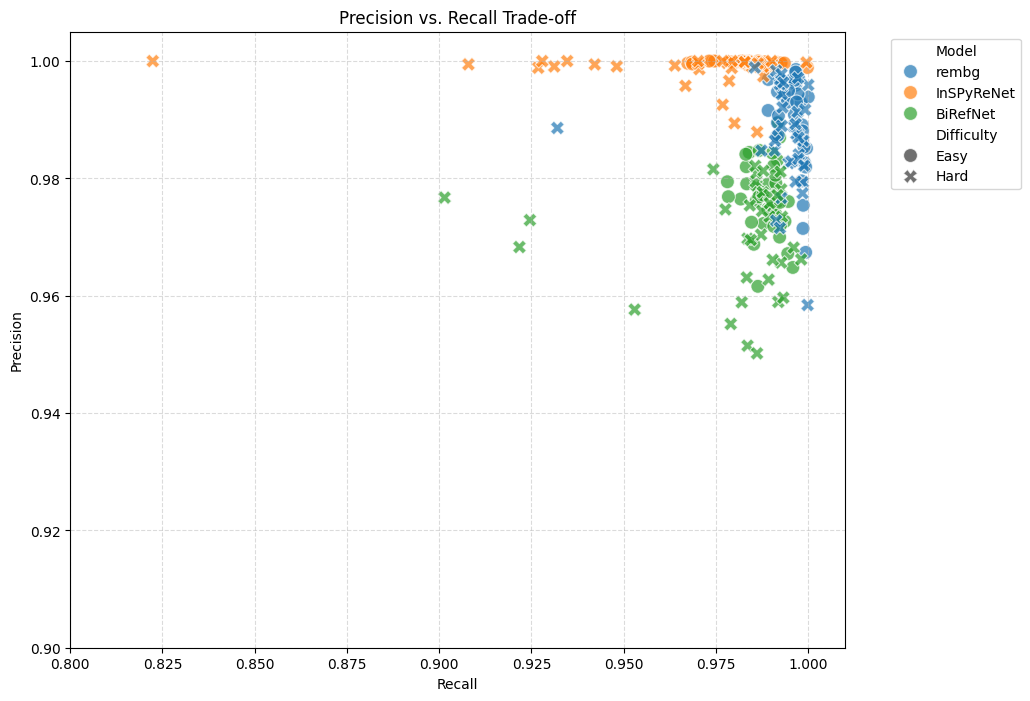

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Win rate per model, for F-beta score
best_models = df.loc[df.groupby("Image")["F_beta"].idxmax()]

win_counts = best_models["Model"].value_counts().reset_index()
win_counts.columns = ["Model", "Wins"]
plt.figure(figsize=(5,4))
ax = sns.barplot(data=win_counts, x="Model", y="Wins", palette="viridis")
plt.title("Number of Images where Model Performed the 'Best'")
plt.ylabel("Count of 'Best' Results")
for i in ax.containers:
    ax.bar_label(i,)
plt.show()


#Scatter graph for precision vs recall, per model.
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df, x="Recall", y="Precision",
    hue="Model", style="Difficulty",
    s=100, alpha=0.7,
)
plt.title("Precision vs. Recall Trade-off")
plt.xlim(0.8, 1.01)
plt.ylim(0.9, 1.005)
plt.grid(True, linestyle='--', alpha=0.45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()